In [66]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/bregression/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)


<module 'postprocessing_utils' from '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/bregression/python/postprocessing_utils.pyc'>

In [67]:
ntuples = 'heppy_05_10_2017'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n

ttbar= [s for s in files if "ttbar" in s]

utils.IO.add_target(ntuples,ttbar,1)
utils.IO.add_features(ntuples,ttbar,1)

for i in range(len(utils.IO.targetName)):        
    print "using target file n."+str(i)+": "+utils.IO.targetName[i]
for i in range(len(utils.IO.featuresName)):        
    print "using features file n."+str(i)+": "+utils.IO.featuresName[i]

env: data=/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017
using target file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet.root
using features file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet.root


In [117]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
#noexpand:fabs(CosThetaStar_CS)
branch_names = 'Jet_pt,Jet_mcPtq,Jet_mcFlavour,dR,rho,Jet_eta,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")

features = 'Jet_pt,rho,Jet_eta,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")
target = 'Jet_mcPtq'.split(",")
cuts='Jet_mcPtq > 15 and dR < 0.35 and (Jet_mcFlavour==5 or Jet_mcFlavour==-5)'

branch_names = [c.strip() for c in branch_names]
features = [c.strip() for c in features]
target = [c.strip() for c in target]

print branch_names

import pandas as pd
import root_pandas as rpd

#preprocessing.set_signals_and_backgrounds("tree",branch_names)
X_features = preprocessing.set_features("tree",branch_names,features,cuts)
X_target = preprocessing.set_target("tree",branch_names,target,cuts)
#print len(X_features),len(X_target)
X_features,X_target=preprocessing.randomize_ft(X_features,X_target)
#print X_features,X_target

#print (X_features).size, len(X_features)
#print (X_target).size, len(X_target)

X_train_target = preprocessing.get_training_sample(pd.DataFrame(X_target))
X_train_features = preprocessing.get_training_sample(pd.DataFrame(X_features))

X_test_target = preprocessing.get_test_sample(pd.DataFrame(X_target))
X_test_features = preprocessing.get_test_sample(pd.DataFrame(X_features))


#print X_train_features, X_test_features
#print type(X_train_target)

#X_train_target,X_train_features = preprocessing.get_total_training_sample(pd.DataFrame(X_target),pd.DataFrame(X_features))
#X_test_target,X_test_features = preprocessing.get_total_test_sample(pd.DataFrame(X_target),pd.DataFrame(X_features))


#X_target_data =  pd.DataFrame(utils.IO.data_df[0],columns=['Jet_mcPt'])
#print X_target_data
#X_data_target = utils.IO.data_df[0][['Jet_mcPt']]
#print X_data_target.shape
#new_jet_mcPt = jet_mcPt.query('Jet_mcPt > 30')
#print new_jet_mcPt
#print type(jet_mcPt)

from sklearn.externals import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

#log_names='Jet_mcPt,Jet_pt'.split(",")
#plotting.plot_input_variables_reg(X_data,branch_names,log_names)
#plt.show()

#X_train_features = preprocessing.get_training_sample(pd.DataFrame(X_data))
#X_test = preprocessing.get_test_sample(pd.DataFrame(X_data))


['Jet_pt', 'Jet_mcPtq', 'Jet_mcFlavour', 'dR', 'rho', 'Jet_eta', 'Jet_mt', 'Jet_leadTrackPt', 'Jet_leptonPtRel', 'Jet_leptonPt', 'Jet_leptonDeltaR', 'Jet_neHEF', 'Jet_chMult', 'Jet_vtxPt', 'Jet_vtxMass', 'Jet_vtx3dL', 'Jet_vtxNtrk', 'Jet_vtx3deL']
              0         1        2          3         4        5         6   \
40014  188.74246  11.43788  0.65540  192.52634  35.71875  5.18568  35.71905   
40015   77.14336  10.20786 -0.01047   78.62681  16.62500  0.00000   0.00000   

            7        8    9         10       11       12   13        14  
40014  0.15105  0.06573  0.0  45.28666  1.48086  1.90717  2.0  54.97556  
40015  0.00000  0.06252  0.0  17.07306  1.90796  0.09940  2.0   3.49792  


In [124]:
########final optimization with all fixed#######

from sklearn.externals import joblib
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error

clf = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=None, n_estimators=1500, nthread=20,
       objective='reg:linear', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
clf.fit(X_train_features,X_train_target)
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH_devel/bregression/output_files/regression_heppy_01.pkl'), compress=9)
predictions = clf.predict(X_test_features)
print predictions, predictions.shape
actuals = X_test_target
true = (actuals.as_matrix()).ravel()
recoPt = (X_test_features[0].as_matrix()).ravel()
print true, true.shape
print true[0]/predictions[0]
ratio = true/predictions
ratio=1/ratio
reco_ratio=true/recoPt
reco_ratio=1./reco_ratio
print ratio.shape
print ratio


#print(mean_squared_error(actuals, predictions))
#print type(actuals), type(predictions)



[ 135.19285583   77.44171143   71.61140442 ...,   56.21190643   42.933918
  151.31903076] (40015,)
[ 103.93473053   83.97959137   50.51187897 ...,   60.43241882   34.2564888
  140.76576233] (40015,)
0.768789
(40015,)
[ 1.30074763  0.92214924  1.41771412 ...,  0.93016148  1.2533077
  1.07497036]


hello
<type 'numpy.ndarray'>


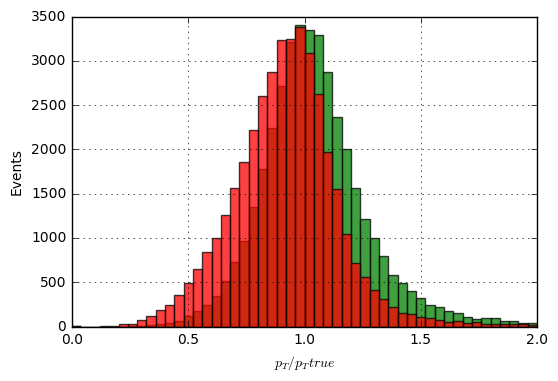

1.0409381152 0.91878612236


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: ratio (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: reco_ratio (Potential memory leak).
Info in <TCanvas::Print>: png file test.png has been created


In [149]:
import matplotlib.pyplot as plt
import ROOT
from ROOT import *

print 'hello'
fake_ratio=ratio-0.5
print type(ratio)
n, bins, patches = plt.hist(ratio, 50, range=(0,2),normed=0, facecolor='g', alpha=0.75,label='regressed')
n2, bins2, patches2 = plt.hist(reco_ratio, 50, range=(0,2),normed=0, facecolor='r', alpha=0.75,label='reco')

plt.grid(True)
plt.ylabel('Events')
plt.xlabel('$p_{T}/p_T true$')

plt.show()


gROOT.Reset()
c1 = TCanvas( 'c1', 'Example with Formula', 200, 10, 700, 500 )
c1.SetGridx()
c1.SetGridy()

hratio = TH1D("ratio", "ratio", 50, 0, 2)
for i in xrange(len(ratio)): 
    hratio.Fill(ratio[i])
hreco_ratio = TH1D("reco_ratio", "reco_ratio", 50, 0, 2)
for i in xrange(len(reco_ratio)): 
    hreco_ratio.Fill(reco_ratio[i]) 
hratio.Draw()
hreco_ratio.Draw("same")
c1.Update()
c1.SaveAs("test.png")
print hratio.GetMean(), hreco_ratio.GetMean()

#plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_noDR_minDRGJet_dijetMass")
#plt.show()
#fpr_gJets_2ndtest_2,tpr_gJets_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString="xgbr_gJets_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()
#fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString="xgbr_diphotons_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()

[ 0.03]
